In [12]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from glob import glob
from tensorflow import keras
from keras import layers, models, regularizers
from keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

Stage: Data Reading/Data Understanding

In [11]:
#	Defined the path for both train and test images from dataset.
train_data = pathlib.Path("/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
test_data = pathlib.Path("/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [13]:
len(list(train_data.glob('*/*.jpg')))

2239

In [14]:
len(list(test_data.glob('*/*.jpg')))

118

Stage: Dataset creation

In [15]:
batch_size = 32
img_height = 180
img_width = 180

In [16]:
# Create the training and validation datasets with 80-20 split
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_data,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [17]:
# Create the validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_data,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [18]:
# List out all the classes of skin cancer and store them in a list.
train_ds.class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

Stage: Dataset visualisation

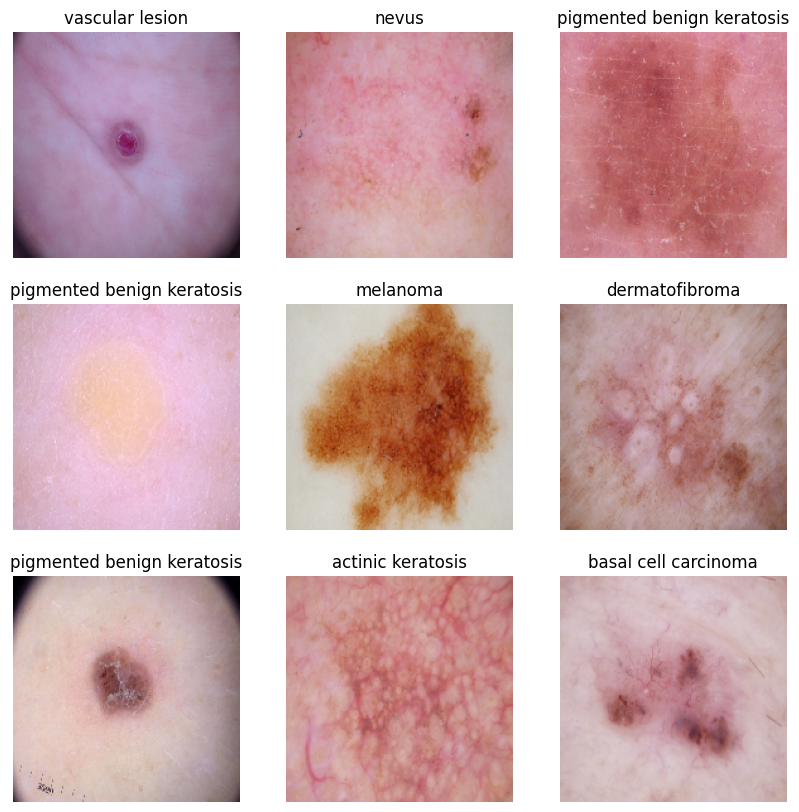

In [19]:
# visualize one instance of all the nine classes present in the dataset
class_names = train_ds.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [20]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Stage: Model Building & training

In [21]:
# Define the CNN model
model = models.Sequential([

    # Rescaling layer to normalize pixel values to [0, 1]
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

    # First convolutional layer
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    # Second convolutional layer
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    # Third convolutional layer
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    # Flatten the output of the convolutional layers
    layers.Flatten(),

    # Dense layer with 512 units
    layers.Dense(512, activation='relu'),

    # Output layer for 9 classes with softmax activation
    layers.Dense(9, activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [22]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 61952)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      31,719,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           4,617 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,817,801 (121.38 MB)

 Trainable params: 31,817,801 (121.38 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 445s 4s/step - accuracy: 0.2340 - loss: 2.5983 - val_accuracy: 0.3714 - val_loss: 1.7118
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 197s 4s/step - accuracy: 0.4042 - loss: 1.6745 - val_accuracy: 0.4653 - val_loss: 1.5560
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 190s 3s/step - accuracy: 0.4674 - loss: 1.4882 - val_accuracy: 0.5235 - val_loss: 1.5185
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 202s 3s/step - accuracy: 0.5148 - loss: 1.3561 - val_accuracy: 0.5101 - val_loss: 1.5053
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 209s 4s/step - accuracy: 0.5850 - loss: 1.1993 - val_accuracy: 0.5302 - val_loss: 1.3638
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 193s 3s/step - accuracy: 0.6039 - loss: 1.1122 - val_accuracy: 0.5414 - val_loss: 1.4042
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 215s 4s/step - accuracy: 0.6219 - loss: 1.0584 - val_accuracy: 0.5481 - val_loss: 1.4548
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 197s 3s/step - accuracy: 0.6485 - loss: 0.9851 - val_accuracy: 0.5526 - v

In [25]:
# Plot training history
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

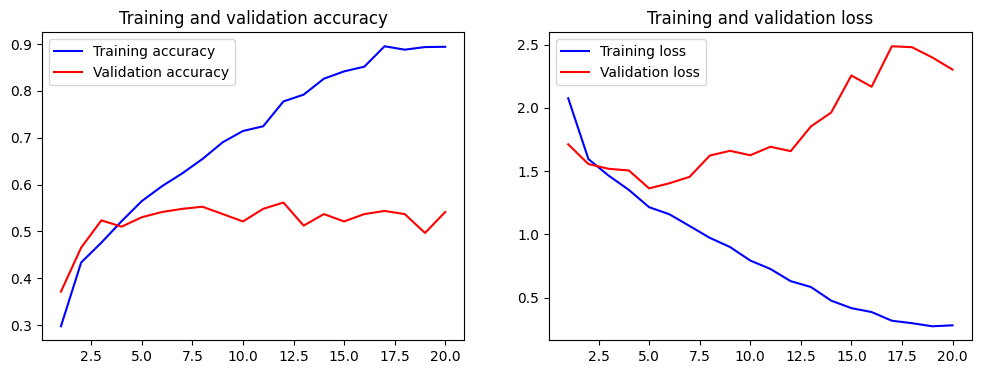

In [26]:
plot_history(history)

Observations:

---


Training accuracy improves steadily, but validation accuracy plateaus and fluctuates, indicating possible overfitting.

Training loss decreases consistently, while validation loss increases after a point, confirming overfitting.

Stage: Data augmentation

In [27]:
# Data augmentation for training data
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

# No augmentation for validation data
val_datagen = ImageDataGenerator(
    validation_split=0.2
)

# Load training data with augmentation (subset='training')
train_ds_aug = datagen.flow_from_directory(
    train_data,
    target_size=(180, 180),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    seed=123
)

# Load validation data without augmentation (subset='validation')
val_ds = val_datagen.flow_from_directory(
    train_data,
    target_size=(180, 180),
    class_mode='categorical',
    subset='validation',
    seed=123
)

Found 1795 images belonging to 9 classes.
Found 444 images belonging to 9 classes.


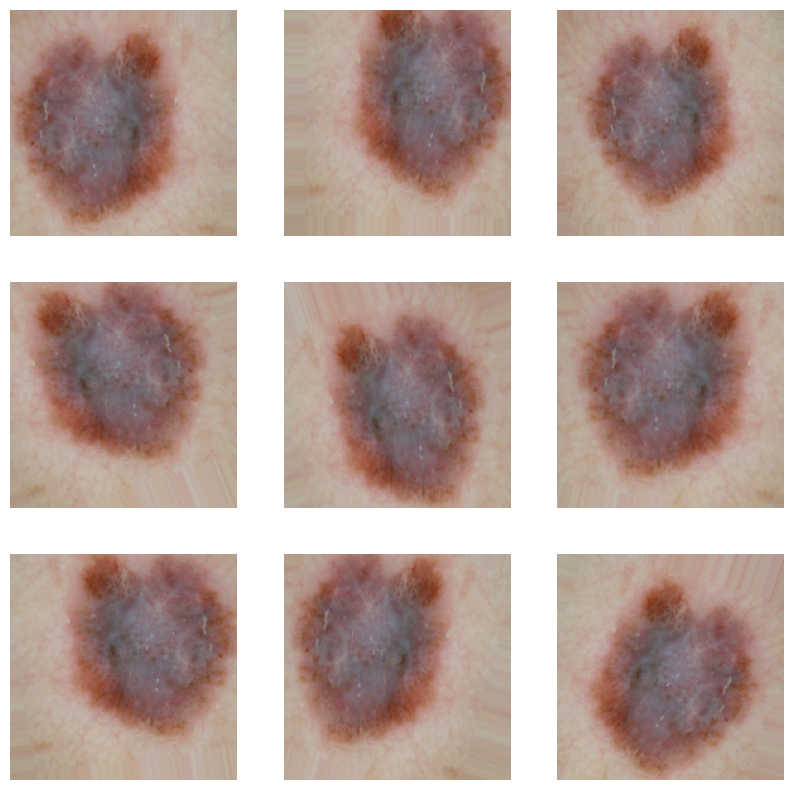

In [28]:
# Visualizing how augmentation strategy works for one instance of training image.

# Load one image from the training dataset
for images, _ in train_ds.take(1):
    img = images[0].numpy().astype('uint8')  # Take the first image and convert it to numpy array

# Reshape the image for the generator
img = np.expand_dims(img, 0)

# Generate augmented images from the single image
augmented_images = datagen.flow(img, batch_size=1)

# Plot the augmented images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    aug_img = next(augmented_images)[0].astype('uint8')
    plt.imshow(aug_img)
    plt.axis('off')

plt.show()

In [29]:
# Define the CNN model with Dropout layers
model_aug = models.Sequential([

    # Rescaling layer to normalize pixel values to [0, 1]
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

    # First convolutional layer
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),


    # Second convolutional layer
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),



    # Third convolutional layer
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),



    # Flatten the output of the convolutional layers
    layers.Flatten(),

    # Dense layer with Dropout
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),  # Dropout with 50% rate to prevent overfitting

    # Output layer for 9 classes with softmax activation
    layers.Dense(9, activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [30]:
model_aug.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [31]:
model_aug.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 61952)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │      15,859,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 9)                   │           2,313 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,955,529 (60.87 MB)

 Trainable params: 15,955,529 (60.87 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
history_aug = model_aug.fit(
  train_ds_aug,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


57/57 ━━━━━━━━━━━━━━━━━━━━ 222s 4s/step - accuracy: 0.1764 - loss: 2.7203 - val_accuracy: 0.2072 - val_loss: 2.2394
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 226s 4s/step - accuracy: 0.2359 - loss: 2.1751 - val_accuracy: 0.2185 - val_loss: 1.9899
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 219s 4s/step - accuracy: 0.3297 - loss: 1.9359 - val_accuracy: 0.3626 - val_loss: 1.8234
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 260s 4s/step - accuracy: 0.3727 - loss: 1.8360 - val_accuracy: 0.3806 - val_loss: 1.8311
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 228s 4s/step - accuracy: 0.4600 - loss: 1.6107 - val_accuracy: 0.4099 - val_loss: 1.8996
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 249s 4s/step - accuracy: 0.4712 - loss: 1.6127 - val_accuracy: 0.4865 - val_loss: 1.7544
Epoch 7/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 216s 4s/step - accuracy: 0.4775 - loss: 1.5932 - val_accuracy: 0.3739 - val_loss: 1.9275
Epoch 8/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 263s 4s/step - accuracy: 0.5225 - loss: 1.4928 - val_accuracy: 0.4279 - val_loss: 1.

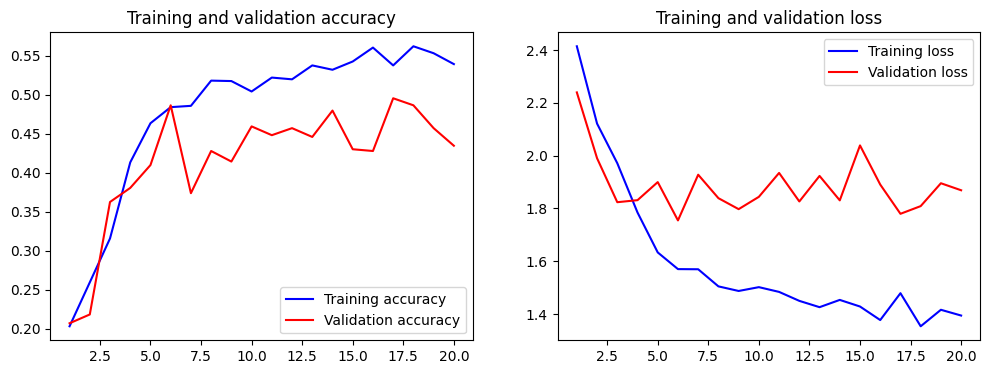

In [33]:
plot_history(history_aug)

Observation:

---


Training accuracy steadily increases, while validation accuracy fluctuates without significant improvement, indicating limited generalization.
Training loss decreases consistently, but validation loss remains high and unstable, further suggesting overfitting.

Stage: Class distribution

In [34]:
# Generate a list of all image file paths in the training data directory.
path_list = [ x for x in glob(os.path.join(train_data, '*', '*.jpg')) ]

# Extract the lesion labels by taking the name of the parent directory for each image.
lesion_list = [ os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(train_data, '*', '*.jpg')) ]

# Print the total number of labels.
print(len(lesion_list))

2239


In [35]:
# Create a dictionary that maps each image file path to its corresponding lesion label.
df_dict_original = dict(zip(path_list, lesion_list))
print(list(df_dict_original.items())[:2])

[('/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0027334.jpg', 'actinic keratosis'), ('/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0027254.jpg', 'actinic keratosis')]


In [36]:
# Convert the dictionary of image paths and labels into a Pandas DataFrame.
original_df = pd.DataFrame(list(df_dict_original.items()), columns=['Path','Label'])
original_df.head()

,Path,Label
0,/content/drive/MyDrive/CNN_assignment/Skin can...,actinic keratosis
1,/content/drive/MyDrive/CNN_assignment/Skin can...,actinic keratosis
2,/content/drive/MyDrive/CNN_assignment/Skin can...,actinic keratosis
3,/content/drive/MyDrive/CNN_assignment/Skin can...,actinic keratosis
4,/content/drive/MyDrive/CNN_assignment/Skin can...,actinic keratosis


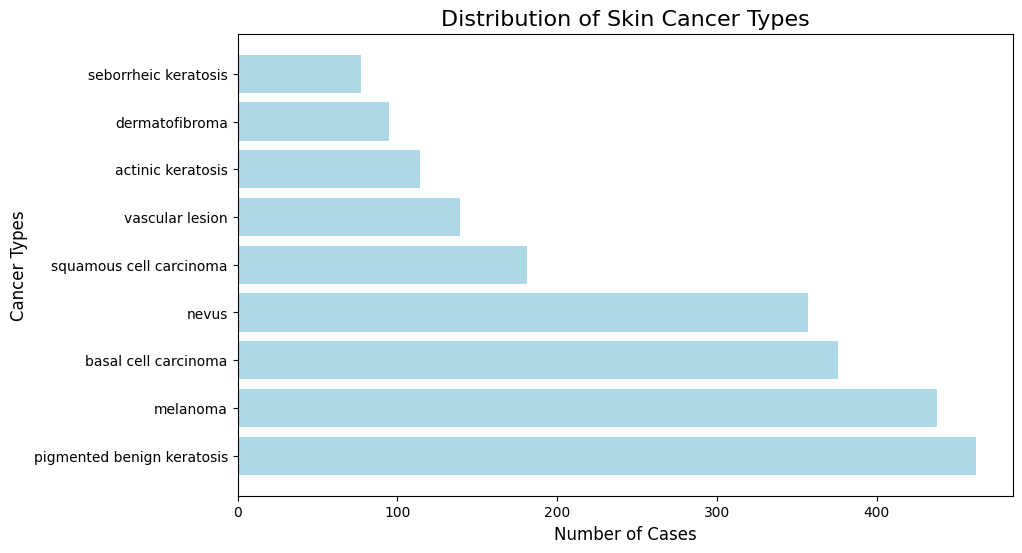

In [37]:
value_counts = original_df['Label'].value_counts()

# Create a horizontal bar plot
plt.figure(figsize=(10, 6))
plt.barh(value_counts.index, value_counts.values, color='lightblue')

# Add title and labels
plt.title('Distribution of Skin Cancer Types', fontsize=16)
plt.xlabel('Number of Cases', fontsize=12)
plt.ylabel('Cancer Types', fontsize=12)

# Display the plot
plt.show()

Observations
Seborrheic keratosis class has the least number of samples.

Pigmented benign keratosis, melanoma, basal cell carcinoma and nevus classes dominate the data in terms proportionate number of samples.

In [39]:
!pip install Augmentor

In [40]:
import Augmentor

In [41]:
path_to_training_dataset = str(train_data) + '/'
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C2435E9B2E0>: 100%|██████████| 500/500 [00:37<00:00, 13.43 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C2435EDBBB0>: 100%|██████████| 500/500 [00:24<00:00, 20.62 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C2440F575B0>: 100%|██████████| 500/500 [00:26<00:00, 18.81 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7C2440366230>: 100%|██████████| 500/500 [01:47<00:00,  4.67 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7C2435D0EE60>: 100%|██████████| 500/500 [01:42<00:00,  4.86 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C2435F49A80>: 100%|██████████| 500/500 [00:24<00:00, 20.03 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7C244035E2F0>: 100%|██████████| 500/500 [00:50<00:00,  9.89 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C24402EC070>: 100%|██████████| 500/500 [00:25<00:00, 19.50 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C24403645B0>: 100%|██████████| 500/500 [00:24<00:00, 20.12 Samples/s]


In [42]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new[:2]

['/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027950.jpg_ce0330cc-d605-4491-865c-3163c06fee12.jpg',
 '/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0025957.jpg_03e1ad28-8f74-49d6-ba76-11f96b51ad0e.jpg']

In [43]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new[:2]

['actinic keratosis', 'actinic keratosis']

In [44]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [45]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = pd.concat([original_df, df2], ignore_index=True)

# Check the shape of the new DataFrame
new_df.shape

(6739, 2)

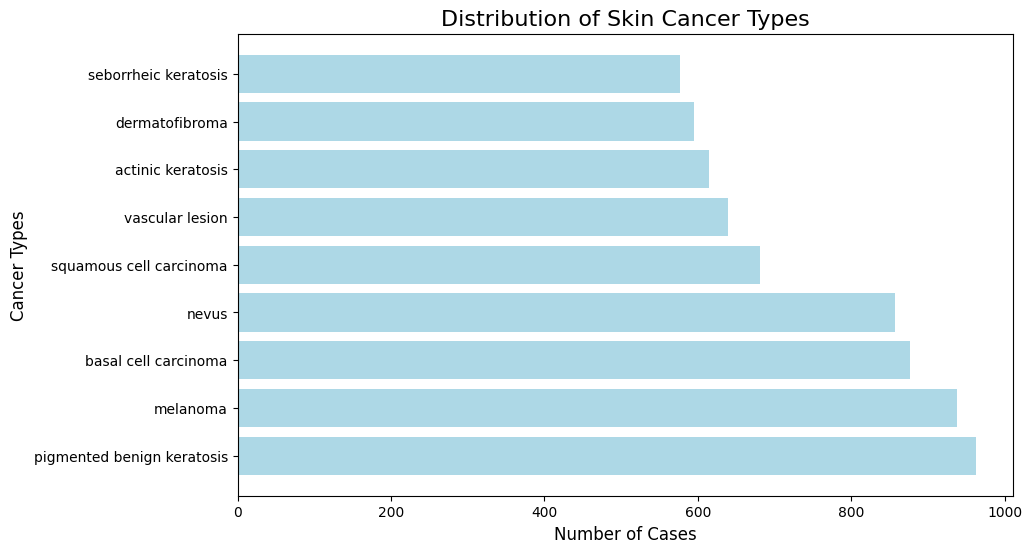

In [46]:
value_counts = new_df['Label'].value_counts()

# Create a horizontal bar plot
plt.figure(figsize=(10, 6))
plt.barh(value_counts.index, value_counts.values, color='lightblue')

# Add title and labels
plt.title('Distribution of Skin Cancer Types', fontsize=16)
plt.xlabel('Number of Cases', fontsize=12)
plt.ylabel('Cancer Types', fontsize=12)

# Display the plot
plt.show()

In [47]:
train_datagen = ImageDataGenerator(
    validation_split=0.2  # Split the training data into train and validation sets
)

# Prepare training and validation datasets
train_dataset = train_datagen.flow_from_directory(
    train_data,
    seed = 123,
    target_size=(180, 180),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_dataset = train_datagen.flow_from_directory(
    train_data,
    seed = 123,
    target_size=(180, 180),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 5395 images belonging to 9 classes.
Found 1344 images belonging to 9 classes.


In [48]:
model_bal = models.Sequential([

    # Rescaling layer to normalize pixel values to [0, 1]
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3),),

    # First convolutional layer with Dropout
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),



    # Second convolutional layer with Dropout
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),



    # Third convolutional layer with Dropout
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),



    # Flatten the output of the convolutional layers
    layers.Flatten(),

    # Dense layer with Dropout
    layers.Dense(512, activation='relu',kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),  # Dropout with 50% rate to prevent overfitting

    # Output layer for 9 classes with softmax activation
    layers.Dense(9, activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [49]:
model_bal.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [50]:
epochs = 20
history_bal = model_bal.fit(
  train_dataset,
  validation_data=val_dataset,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


169/169 ━━━━━━━━━━━━━━━━━━━━ 947s 6s/step - accuracy: 0.3538 - loss: 4.0408 - val_accuracy: 0.1302 - val_loss: 4.4904
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 992s 6s/step - accuracy: 0.5193 - loss: 2.7713 - val_accuracy: 0.1555 - val_loss: 4.3391
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 915s 5s/step - accuracy: 0.5936 - loss: 2.2772 - val_accuracy: 0.4100 - val_loss: 2.8395
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 932s 5s/step - accuracy: 0.6688 - loss: 2.0563 - val_accuracy: 0.3088 - val_loss: 3.2744
Epoch 5/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 994s 6s/step - accuracy: 0.7023 - loss: 2.0022 - val_accuracy: 0.2917 - val_loss: 4.3071
Epoch 6/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 1001s 6s/step - accuracy: 0.7093 - loss: 2.2370 - val_accuracy: 0.4792 - val_loss: 3.1694
Epoch 7/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 936s 6s/step - accuracy: 0.7300 - loss: 2.3319 - val_accuracy: 0.4896 - val_loss: 3.2667
Epoch 8/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 930s 5s/step - accuracy: 0.7932 - loss: 2.2351 - val_accuracy: 0.35

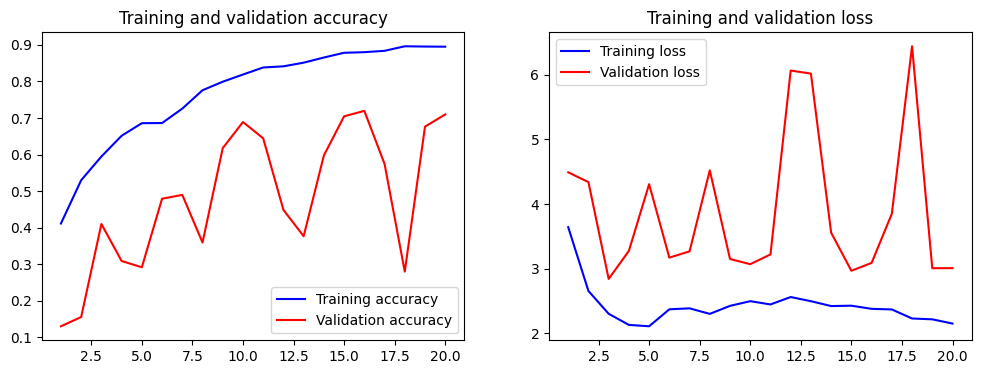

In [51]:
plot_history(history_bal)

Observations
Training accuracy steadily increases and reaches high levels, but validation accuracy is highly unstable, indicating poor generalization.

Training loss decreases steadily, while validation loss fluctuates widely, confirming instability and potential overfitting.

After using batch normalization, there is large fluctuations in validation metrics suggesting instability and a need for improvements like regularization